## Diffusion Model using U-Net

This is an appendix notebook that is optional to the reader. It contains code for training a diffusion model using a U-Net architecture. The idea was to train on the `disgust` category to upsample for our models but it ultimately failed. However, we learned a lot about diffusion models and Kaylee finally found her spark after a decade of searching.

*Citing our sources, parts of this notebook was AI assisted via DeepSeek. The functions marked with "AI" were AI assisted.*

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [ ]:
# Determinisitc, relative embeddings
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        # had to use device because it was giving errors
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

The positional embeddings, just like in the transformer paper (Vaswani et al., 2017) are defined as follows:

$$
PE_{pos}(t) = \begin{cases}
\sin(\frac{t}{10000^{\frac{2i}{d}}}) & \text{if } i \text{ is even} \\

\cos(\frac{t}{10000^{\frac{2i-1}{d}}}) & \text{if } i \text{ is odd}
\end{cases}
$$

The pytorch code looks slightly different but it is equivalent. We use a similar approach to (Kubo, 2024) as a more efficient way to compute the positional embeddings. These embeddings are non-trainable and represent relative positions in a time sequence. This is in contrast to vision transformers, which have learnable positional embeddings. 

Positional embeddings are used to encode the time step information into the model. These embeddings are fed into the residual blocks of the U-Net as a additional feature map. This is akin to conditional generative adversarial networks (cGANs) where the condition is added as an additional feature map.

Next, we create a class for the attention block The attention block is the standard attention block we have all seen before. The only difference is that we use a linear layer instead of a convolutional layer to compute the query, key and value matrices. The attention block allows the model to focus on different parts of the input image.

In [ ]:
# Very similar to HW5 attention block
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # batch, channels, height, width
        B, C, H, W = x.shape

        # Q, K, V projections
        query = self.query(x).view(B, -1, H * W)
        key = self.key(x).view(B, -1, H * W)
        value = self.value(x).view(B, -1, H * W)

        attention_map = torch.matmul(query.transpose(1, 2), key)
        attention_map = self.softmax(attention_map)
        out = torch.matmul(attention_map, value.transpose(1, 2))

        out = out.transpose(1, 2).view(B, C, H, W)

        return out

For the next class, we create a residual block. A lot of the code was taken from a medium post (Dz, 2023). The architecture as defined in the init contains two convolutional layers, a group normalization, attention block and a skip connection. Group norm is essentially identical to batch norm but it is batch size agnostic. For all intents and purposes, one can view it as a bathch norm layer. 

In the forward pass, we apply convolution, project the time embedding and add it as an additional feature map. We then apply convolution again and pass the result through an attention block. The final step is a skip connection.

In [ ]:
# Residual Block with Time Embedding and Attention
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act2 = nn.SiLU()

        # Inject the time embedding into the block
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.attn = AttentionBlock(out_channels)
        self.res_conv = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t_emb):
        h = self.act1(self.norm1(self.conv1(x)))
        # Add the time embedding as another feature map
        h = h + self.time_mlp(t_emb).view(t_emb.size(0), -1, 1, 1)
        h = self.act2(self.norm2(self.conv2(h)))
        h = self.attn(h)
        # Add the residual connection
        return h + self.res_conv(x)

The class below is just a U-Net. There's not much to add here since we used U-Net extensively in the main project. It's the standard encoder, bottleneck, decoder architecture with long skip connections. We alo use residual blocks with attention instead of vanilla convolution blocks. 

In [ ]:
# U-Net Architecture
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 256
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        ## Define the architecture
        # Encoder
        self.enc1 = ResBlock(1, 64, time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResBlock(64, 128, time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResBlock(128, 256, time_emb_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = ResBlock(256, 128, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ResBlock(128, 64, time_emb_dim)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    ## Define the forward pass
    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        t_emb = self.time_mlp(t_emb)

        # Encoder
        e1 = self.enc1(x, t_emb)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1, t_emb)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2, t_emb)

        # Decoder
        up1 = self.up1(b)
        d1 = self.dec1(torch.cat([up1, e2], dim=1), t_emb)

        up2 = self.up2(d1)
        d2 = self.dec2(torch.cat([up2, e1], dim=1), t_emb)

        return self.out(d2)

The model has been defined. Now we move on the interesting part, the training loop. First we define the forward process. The forward process is a Markov chain that progressively adds noise to the data. The noise is drawn from a multivariate standard normal. We define the forward process as

$$
\begin{equation}
q(x_t | x_{t-1}) = \mathcal{N}(\mu_t = \sqrt{1 - \beta_t} x_{t-1}, \sigma_t^2 = \beta_t I).
\end{equation}
$$

The variance schedule is defined as $\beta_t$. In the class below, we use a linear schedule. Cosine schedules have been shown to be better but we stick to linear for simplicity (Nichol & Dhariwal, 2021). The variable $x_t$ is the image at time $t$ and by the Markov assumption, the image at time $t$ only depends on the image at time $t-1$. Like shown in lecture, we reparameterize the forward process using the following equations:

$$
\alpha_t = 1 - \beta_t,
$$
$$
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s.
$$

Equation 1 now becomes

$$
q(x_t | x_0) = \mathcal{N}(\mu_t = \sqrt{\bar{\alpha}_t} x_0, \sigma_t^2 = (1 - \bar{\alpha}_t) I).
$$

All variables have been defined. The class below implements the forward process.


In [ ]:
# Forward process of the diffusion model
class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        # need to be on same device
        # was getting same bug as before
        device = x_start.device
        alphas_cumprod = self.alphas_cumprod.to(device)
        sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]

        return sqrt_alpha_cumprod * x_start + sqrt_one_minus * noise


**Author's Notes**

Since the training loop was only introduced in the last lecture, we had to use DeepSeek for help. The general concept was clear but the implementation was not. The tricky part was step 4 and 5 because it was vague on what to do about 'take gradient step on $\nabla_\theta || \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t)||^2$'. The AI was able to clarify this and the code below is the result of that.

We follow the steps outlined in the paper "Denoising Diffusion Probabilistic Models" (Ho et al., 2020). The steps can be found on slide 42 of the final lecture. The steps are as follows:

<img src="./img/diffusion_train.png" width="650" height="325">

In [ ]:
# AI-assisted
class DiffusionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Denoising model, model to predict the noise
        self.model = SimpleUNet()

        # Foward process
        self.diffusion = Diffusion()

    def forward(self, x, t):
        # Inputs are x and time step t
        return self.model(x, t)

    def training_step(self, batch, batch_idx):

        # Step 1: sample images
        x, _ = batch

        # Step 2: Sample time step from a uniform distribution
        t = torch.randint(
            0, self.diffusion.timesteps, (x.size(0),), device=self.device
        ).long()

        # Step 3: Sample noise
        noise = torch.randn_like(x, device=self.device)

        # Step 4: Generates noisy images
        x_noisy = self.diffusion.q_sample(x, t, noise)

        # Step 5: Predict the noise
        noise_pred = self(x_noisy, t)

        # Compute the MSE
        loss = F.mse_loss(noise_pred, noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

In [ ]:
# 4. Prepare the DataLoader for FER-2013 Dataset
transform = transforms.Compose(
    [
        transforms.Grayscale(),  # in case it's not grayscale
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
    ]
)

In [ ]:
# Update the path to the FER-2013 dataset on your system
train_dataset = datasets.ImageFolder(
    "./data/clean_train_diffusion", transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = DiffusionModel()
trainer = pl.Trainer(max_epochs=1000, accelerator="auto")
trainer.fit(model, train_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-05-07 20:44:28.425586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 20:44:28.425632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register fac

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


**Author's Notes**

Sampling was trickiest because we barely covered it in the lecture. We knew the general idea is to feed in a noise vector and then iteratively denoise it but how to do so was not clear. The breakthrough occurred when we realized the process can be viewed as solving a stochastic differential equation (SDE), specifically a variance preserving SDE. Framing it this way made it clear why we have a $\sigma_t$ term and what the denoising equation is doing.

Sampling is where we take a noise vector and iteratively denoise it. We do so by using a special equation

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)) + \sigma_t z.
$$

The equation takes as input the noise vector $x_t$, time step $t$ and the model prediction $\epsilon_\theta(x_t, t)$. The $\sigma_t$ term is added to introduce noise because the forward process is stochastic and therefore the reverse process must also be stochastic. It ensures mathematical consistency for the stochastic differential equation (SDE) we are solving.


<img src="./img/diffusion_sample.png" width="650" height="325">

In [ ]:
# AI-assisted
@torch.no_grad()
def generate_image(
    model,
    diffusion,
    image_size=(1, 48, 48),
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    model.eval()
    model.to(device)

    # Step 1: Sample random noise
    img = torch.randn(1, *image_size, device=device)

    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((1,), t, device=device, dtype=torch.long)

        # Predict the noise
        noise_pred = model(img, t_tensor)

        # Get alpha parameters
        alpha_t = diffusion.alphas[t].to(device)
        alpha_cumprod_t = diffusion.alphas_cumprod[t].to(device)
        beta_t = diffusion.betas[t].to(device)

        # Step 4: Apply the noise reversing formula
        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1 - alpha_cumprod_t)
        img = coef1 * (img - coef2 * noise_pred)

        # Step 3
        # Add noise except for last step
        # we want final image to be clean
        if t > 0:
            noise = torch.randn_like(img)
            sigma_t = torch.sqrt(beta_t)
            img += sigma_t * noise

    img = torch.clamp(img, -1.0, 1.0)
    img = (img + 1) / 2
    return img

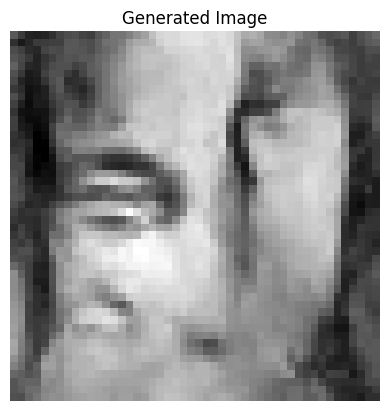

In [18]:
# Generate an image
generated_image = generate_image(model, model.diffusion)

# Convert to numpy
img_np = generated_image.squeeze().cpu().numpy()

# Plot
import matplotlib.pyplot as plt

plt.imshow(img_np, cmap="gray")
plt.axis("off")
plt.title("Generated Image")
plt.show()

The results are subpar. Generating human faces with specific emotions is a very difficult task that most likely cannot be solved with this approach. The image above looks like noise but we can discern a few characteristics of a face. We can see the model is learning the shape of the face and the background. We can see evidence of eyes and a nose.

## Sources

Dz. (2023, September 17). Intro to Diffusion Model — Part 5 - DZ - Medium. Medium. https://dzdata.medium.com/intro-to-diffusion-model-part-5-d0af8331871

Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2006.11239

Kubo, H. (2024, December 28). Understanding Transformer sinusoidal Position embedding. Medium. https://medium.com/%40hirok4/understanding-transformer-sinusoidal-position-embedding-7cbaaf3b9f6a

Nichol, A., & Dhariwal, P. (2021, February 18). Improved denoising diffusion probabilistic models. arXiv.org. https://arxiv.org/abs/2102.09672

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017, June 12). Attention is all you need. arXiv.org. https://arxiv.org/abs/1706.03762